## Sentiment Analysis with BERT

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline

import re

import httpx
from selectolax.parser import HTMLParser

from dataclasses import dataclass, asdict

### Functions

In [4]:
# creating a class for data validation
@dataclass
class Review:
    quote:str
    entry:str
    rating:int

In [5]:
def get_data(page_url):
    timeout = httpx.Timeout(5.0)
    headers = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			 AppleWebKit/537.36 (KHTML, like Gecko) \
			 Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})
    try:
        response = httpx.get(page_url,
                             headers=headers,
                             timeout=timeout)
    except Exception as ex :
        print(repr(ex))
    return response

In [6]:
def parse_data():
    pages = [i for i in range(15, 1200, 15) if i % 15 ==0]
    reviews = []
    for page in pages:
        page_url = f"https://www.tripadvisor.com/Restaurant_Review-g186338-d5856902-Reviews-or{page}-Bayleaf_Restaurant-London_England.html"
        response = get_data(page_url)
        parser = HTMLParser(response.text)
        for review in parser.css("div.mobile-more div.review-container div.ui_column.is-9"):
            review = Review(
                quote  = review.css_first(".quote").text(),
                entry  = review.css_first(".entry").text(),
                rating = review.css_first("span").attrs["class"].split("_")[-1][:1])
            reviews.append(asdict(review))
    df = pd.DataFrame.from_dict(reviews)
    df.to_csv("review.csv", index=False)
    print("Completed!")

In [7]:
def model_score(review):
    result = nlp(review)[0]
    return int(result["label"].split()[0])

In [8]:
def process_entry(entry):
    entry = entry.lower().strip()
    entry = re.sub(r"([?.!,])", " ", entry)
    entry = re.sub(r"[^a-z?.!,']+", " ", entry)
    entry = re.sub(r'[" "]+', " ", entry)
    return entry

In [9]:
def visualize():
    sns.histplot(data=reviews, x="rating", label="Rating", discrete=True)
    sns.histplot(data=reviews, x="scores", label="Scores", alpha=0.4, discrete=True)
    sns.despine()
    plt.title("Actual vs Predicted Results")
    plt.xlabel("Rating")
    plt.ylabel("Review Counts")
    plt.grid(axis='y')
    plt.legend()
    plt.show()

### Getting Data

In [11]:
parse_data() # download the data

In [11]:
reviews = pd.read_csv("Data/reviews.csv")

In [12]:
reviews.head()

,quote,entry,rating
0,Amazing,"Lovely delicious food, beautiful waitress, fan...",5
1,Best Indian in Bollington,Outstanding service and amazing curries ! All ...,5
2,Mother's Day treat.,A terrific return after 15 years to the area.\...,5
3,Delicious !,Lovely tasty food. Great selection and good p...,5
4,Loved it!!!!!!!!,"Amazing birthday dinner. The garlic naan, but...",5


In [13]:
reviews.shape

(941, 3)

In [14]:
reviews.isnull().sum()

quote     0
entry     0
rating    0
dtype: int64

### Geting Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = TFAutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


### Sentiment Analysis

In [247]:
# creating new column with predicted data
reviews["scores"] = reviews["entry"].apply(model_score)

In [16]:
#reviews.to_csv("reviews_modified.csv", index=False)
#reviews = pd.read_csv("Data/reviews_modified.csv")

In [17]:
reviews.head()

,quote,entry,rating,scores
0,Amazing,"Lovely delicious food, beautiful waitress, fan...",5,5
1,Best Indian in Bollington,Outstanding service and amazing curries ! All ...,5,5
2,Mother's Day treat.,A terrific return after 15 years to the area.\...,5,5
3,Delicious !,Lovely tasty food. Great selection and good p...,5,5
4,Loved it!!!!!!!!,"Amazing birthday dinner. The garlic naan, but...",5,5


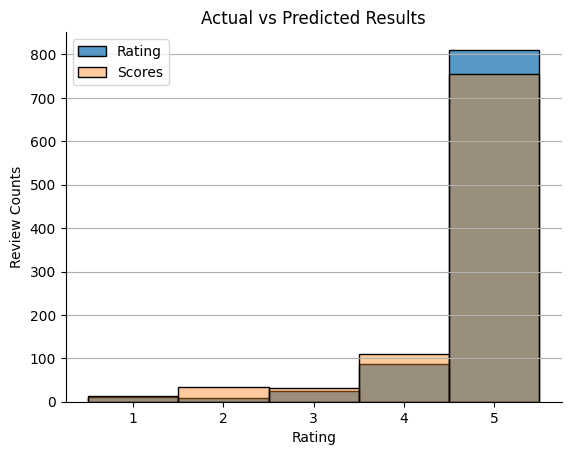

In [18]:
# Comparing predictions to actual values
visualize()